In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics

In [3]:
np.random.seed(7)

# Representing text data in a form suitable for machine learning algorithms

Textual data is unstructured by nature and therefore cannot be used in its raw form for automated analysis and information retrieval. With that being said, before applying machine learning methods it is necessary to perform some kind of preprocessing (such as lowering the text, reducing similar words to same form (lemmatization, stemming), different types of filtering, etc.) Another problem with modeling text is that most of machine learning algorithms require numeric features and fixed-length inputs. There are different techniques for obtaining numerical representations of textual data depending on how and which linguistic properties do we want to represent. This process is called **feature extraction**. Two methods will be presented below - **Bag of Words** and **TF-IDF**.

Dataset (corpus, linguistic term) which we will use to demonstrate these methods contains only two sentences.
Instances do not necessarily have to be sentences, it could be paragraphs, whole text documents or any other textual forms.

In [4]:
corpus = ['I have to have time today to go and buy her a present.', 'Who is going to present next?']

## Bag of Words method

This is one of the simplest and most commonly used methods for text feature extraction. In this model, textual data is represented as the bag (multiset) of its words, disregarding grammatical details (for instance, same word in different contexts can be a verb and a noun) and even word order (e.g. the sentences 'Tom likes Mary' and 'Mary likes Tom' have the same set of words and different semantics) but keeping multiplicity. After transforming the text into a bag of words, the numerical representation is obtained by calculating some of the metrics for quantifying different linguistic properties (presence or frequency of words in the text, TF-IDF measure, etc.).

<u>Procedure</u>: Suppose that in the vocabulary V (the set of all words in the corpus or a predefined set of relevant words) we have |V| words and that they are lexicographically arranged. We can assign ordinal numbers to the words corresponding to their positions in vocabulary. A sentence can therefore be represented as |V|-dimensional vector in which the $i$th element is $1$ if the $i$th word of the vocabulary is present in the sentence, otherwise it is $0$. Very often besides knowing the word presence of importance is to know the number of times some words appear in text (for instance, in topic identification). That is why this representation is usually upgraded so that $i$th element of the vector is the frequency of $i$th word in corresponding sentence. However, word frequencies are not necessarily the best representation because they do not take into account the length of the text - if the text is long, some words may appear unjustifiably with a higher frequency, and vice versa.

<img src="assets/count_vectorizer.png" width=750>

Scikit-learn library provides support for text vectorization using the Bag of Words method with frequencies through the <code>CountVectorizer</code> class. Constructor function has various settings, mainly related to the preprocessing phase:
- <code>lowercase</code> - converting all characters to lowercase before tokenizing
- <code>min_df</code> - lower cutoff value of the frequency values, used for excluding words that have a frequency less than a given threshold (e.g. it is used to filter various spelling errors)
- <code>max_df</code> - upper cutoff value of the frequency values, used for excluding words that have a frequency higher than a given threshold (e.g. it is used to filter very common words such as conjunctions, articles, etc.)
- <code>stop_words</code> - excluding common words or words that are considered irrelevant for the specific problem
- <code>token_pattern</code> - excluding words that do not match a predefined format (e.g. it is used to exclude numbers, dates, etc.)
- <code>tokenizer</code> i <code>preprocessor</code> - passing a custom function to perform tokenization/preprocessing (it can also be used affiliate with functionalities offered by other libraries)
- <code>vocabulary</code> - assigning pre-prepared vocabulary

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
count_vectorizer = CountVectorizer()

Method <code>fit()</code> creates a vocabulary for a given set of texts (corpus).

In [7]:
count_vectorizer.fit(corpus)

CountVectorizer()

A list of extracted features (words) can be obtained by method <code>get_feature_names()</code>.

In [8]:
count_vectorizer.get_feature_names()

['and',
 'buy',
 'go',
 'going',
 'have',
 'her',
 'is',
 'next',
 'present',
 'time',
 'to',
 'today',
 'who']

Extracted atributes (words) and their associated positions within the vector representation can be obtained by object attribute <code>vocabulary_</code>.

In [9]:
count_vectorizer.vocabulary_

{'have': 4,
 'to': 10,
 'time': 9,
 'today': 11,
 'go': 2,
 'and': 0,
 'buy': 1,
 'her': 5,
 'present': 8,
 'who': 12,
 'is': 6,
 'going': 3,
 'next': 7}

In [10]:
len(count_vectorizer.vocabulary_)

13

Method <code>transform()</code> yields vector representations of sentences. In our example, both sentences will be represented by vectors of length $13$, so the result is $2\times13$ matrix.

In [11]:
corpus_bag_of_words = count_vectorizer.transform(corpus)

In [12]:
corpus_bag_of_words.shape

(2, 13)

Matrix of vector representations usually contains a large number of zeros and for such matrices we say that they are **sparse**. Sparse matrices are usually stored in a compressed format that involves saving only triplets <code>(row_index, column_index, value)</code> for non-zero values. Method <code>transform()</code> returns a matrix of vector representations in **CSR format** (Compressed Sparse Row format). In real applications, the size of the vocabulary is usually large (> 10000 words), so this design has a positive effect on both memory usage and 
computational performance.

In [13]:
type(corpus_bag_of_words)

scipy.sparse.csr.csr_matrix

Methods <code>toarray()</code> and <code>todense()</code> can be used to obtain (unravel) dense representation of compressed format matrices. Method <code>toarray()</code> returns the <code>numpy</code> array, while the <code>todense()</code> method returns the <code>sclearn</code> matrix.

In [14]:
corpus_bag_of_words.toarray()

array([[1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 2, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]])

In [15]:
corpus_bag_of_words.todense()

matrix([[1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 2, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]])

## TF-IDF method (Term Frequency - Inverse Document Frequency)

Bag of Words representations (with frequencies) can be further improved by switching to the representation with weights. Weights should reflect the importance of words within a given textual data, but also they should take into account how much information the word provides, i.e., if it's common or rare across all documents. One such representation can be obtained by the **TF-IDF method**, which assigns weights to words based on the **TF-IDF measure**.

<img src="assets/tfidf_vectorizer.png" width=750>

**Calculating TF-IDF measure**

Let it be: 
- $D$ - set of text documents (corpus)
- $d$ - one text document from $D$
- $t$ - one term (word) from $d$

The TF-IDF measure of the term $t$ in document $d$ from the corpus $D$ is calculated as the product of the following two factors:
- $Tf(t, d)$ - frequency of $t$ in $d$ relative to total number of terms in $d$
  $$Tf(t, d) = \frac{N_t^d}{|d|}$$
- $Idf(t, D)$ - logarithmically scaled inverse fraction of the documents in $D$ that contain term $t$ 
  $$Idf(t, D) = log \big(\frac{|D|}{N_t^D}\big)$$

Then TF-IDF is calculated as $$TfIdf(t, d, D) =Tf(t, d)\cdot Idf(t, D)$$

The importance of a term increases with the number of its occurrence in the document (TF), but it decreases with the number of documents in the corpus that contain the word (IDF). In this way, terms that are less discriminatory (which are common, appear in a large number of documents) will be assigned smaller weights. By default, IDF-part is logarithmically scaled in order to put it on the “same scale” as the TF-part, ie. to reduce the influence of the IDF part on the total value of the TF-IDF measure when working with large corpora - then the non-logarithmic IDF explodes and only important become terms found in very few documents, while the terms found in a mediocre and large number of documents have negligible weight (importance). More about on this can be read [here](https://towardsdatascience.com/how-tf-idf-works-3dbf35e568f0). In some versions of TF-IDF measure, the TF-part is also logarithmically scaled for the same reason (when individual documents are large).

A number of term-weighting schemes have derived from TF-IDF. One of them is [TF-PDF](https://www.researchgate.net/publication/4004411_Topic_extraction_from_news_archive_using_TFPDF_algorithm) (Term Frequency - Proportional Document Frequency). TF-PDF was introduced in 2001 in the context of identifying emerging topics in the media. The PDF component measures the difference of how often a term occurs in different domains. Another derivate is TF-IDuF. In [TF-IDuF](https://www.gipp.com/wp-content/papercite-data/pdf/beel17.pdf),  IDF-part is not calculated based on the document corpus that is to be searched or recommended. Instead, IDF is calculated on users' personal document collections. The authors report that TF–IDuF was equally effective as TF-IDF but could also be applied in situations when, e.g., a user modeling system has no access to a global document corpus.

<u>**EXAMPLE**</u>:
    
Let's consider a document $d$ containing $100$ words in which the word (term) 'present' appears $3$ times.

$Tf$('present', $d$) = $\frac{3}{100}$ = $0.03$

Suppose we have $10$ million documents and the word ‘present’ appears in $1000$ of them.

$Idf$('present', $D$) = $\log{(\frac{10 000 000}{1 000})}$ = $4$

Then, $TfIdf$('present', $d$, $D$) = $0.03 \cdot 4$ = $0.12$.

Scikit-learn library provides support for text vectorization using the TF-IDF method through the <code>TfidfVectorizer</code> class. Constructor function has various settings, similar to the ones <code>CountVectorizer</code> had, with the addition of a couple of new ones:
- <code>norm</code> - specifying the metrics to be used to normalize vector representations
- <code>use_idf</code> - enabling/disabling the IDF part in calculating weights
- <code>smooth_idf</code> - smooth IDF weights by adding one to document frequencies, to avoid 0 division when calculating the IDF for terms that are in the vocabulary but did not appear in the corpus (in the case when a pre-prepared vocabulary is assigned, instead of forming on the basis of a given corpus)
- <code>sublinear_tf</code> - logarithmic scaling of TF-part 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tfidf_vectorizer = TfidfVectorizer()

Method <code>fit()</code> creates a vocabulary for a given set of texts (corpus).

In [18]:
tfidf_vectorizer.fit(corpus)

TfidfVectorizer()

A list of extracted features (words) can be obtained by method <code>get_feature_names()</code>.

In [19]:
tfidf_vectorizer.get_feature_names()

['and',
 'buy',
 'go',
 'going',
 'have',
 'her',
 'is',
 'next',
 'present',
 'time',
 'to',
 'today',
 'who']

Extracted features (words) and their associated positions within the vector representation can be obtained by object attribute <code>vocabulary_</code>.

In [20]:
tfidf_vectorizer.vocabulary_

{'have': 4,
 'to': 10,
 'time': 9,
 'today': 11,
 'go': 2,
 'and': 0,
 'buy': 1,
 'her': 5,
 'present': 8,
 'who': 12,
 'is': 6,
 'going': 3,
 'next': 7}

In [21]:
len(tfidf_vectorizer.vocabulary_)

13

Method <code>transform()</code> yields vector representations of sentences. In our example, both sentences will be represented by vectors of length $13$, so the result is $2\times13$ matrix.

In [22]:
corpus_tfidf = tfidf_vectorizer.transform(corpus)

In [23]:
corpus_tfidf.shape

(2, 13)

The values found in this representation are now real numbers, with the vectors always being normalized (by default $l_2$ norm). The matrix of vector representations is still sparce and will be forwarded in CSR format.

In [24]:
type(corpus_tfidf)

scipy.sparse.csr.csr_matrix

Obtaining a dense representation of vectorized sentences is possible using methods <code>toarray()</code> or <code>todense()</code>.

In [25]:
corpus_tfidf.toarray()

array([[0.28249016, 0.28249016, 0.28249016, 0.        , 0.56498032,
        0.28249016, 0.        , 0.        , 0.20099408, 0.28249016,
        0.40198815, 0.28249016, 0.        ],
       [0.        , 0.        , 0.        , 0.44665616, 0.        ,
        0.        , 0.44665616, 0.44665616, 0.31779954, 0.        ,
        0.31779954, 0.        , 0.44665616]])

In [26]:
np.linalg.norm(corpus_tfidf.toarray()[0, :])

1.0

# Example

TSV file <code>'data/SMSSpamCollection.tsv'</code> contains a collection of SMS messages with associated labels
- 'spam' - if the message is spam
- 'ham' - if the message is not spam

The task is to make a classifier that distinguishes spam and non-spam messages.

In [27]:
data = pd.read_csv('data/SMSSpamCollection.tsv', sep='\t', header=None)

In [28]:
data.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Total number of SMS messages:

In [29]:
data.shape[0]

5572

We will use the column with index 0 as the target variable (by assigning numbers 0 and 1 to classes) and column with index 1 will be used for feature extraction over which the model will be trained.

In [30]:
x = data[1]
y = data[0].apply(lambda x : int(x == 'spam'))

Class distribution:

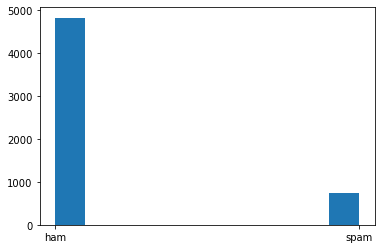

In [31]:
plt.hist(y)
plt.xticks([0, 1], labels=['ham', 'spam'])
plt.show()

Dataset is splitted into a training and test subsets in ratio 2:1, with stratification (parameter <code>stratify</code>). The value of the parameter <code>random_state</code> is fixed in order to make reproducible train test split.

In [32]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, stratify=y, random_state=7)

In [33]:
x_train.shape

(3733,)

In [34]:
x_test.shape

(1839,)

## Text representation using the Bag of Words method (with frequencies)

Firstly we well try with Bag of Words representations (with frequencies) and train several types of classification models. When building a vocabulary, we exclude words that appear less than 2 times.

In [35]:
sms_count_vectorizer = CountVectorizer(min_df=2)

Vocabulary is, by rule, built over a training set. Later, while obtaining vector representations for test set instances, all unknown words (words that are not present in the vocabulary) will be ignored.

In [36]:
sms_count_vectorizer.fit(x_train)

CountVectorizer(min_df=2)

Size of the built vocabulary:

In [37]:
feature_names = sms_count_vectorizer.get_feature_names()

In [38]:
len(feature_names)

3209

Vectorization of training and test set text data:

In [39]:
x_train_vectorized = sms_count_vectorizer.transform(x_train)
x_test_vectorized = sms_count_vectorizer.transform(x_test)

### Model 1 - logistic regression

We construct a simple logistic regression model and train it on a vectorized training set.

In [40]:
model1 = linear_model.LogisticRegression()

In [41]:
model1.fit(x_train_vectorized, y_train)

LogisticRegression()

Accuracy of the model on the training and test set:

In [42]:
model1.score(x_train_vectorized, y_train)

0.995713903027056

In [43]:
model1.score(x_test_vectorized, y_test)

0.9831430125067971

Confusion matrix:

In [44]:
y_test_predicted = model1.predict(x_test_vectorized)

In [45]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1589,    3],
       [  28,  219]])

### Model 2 - linear SVM

We construct a linear SVM (Support Vector Machine) model and train it on a vectorized training set.

In [46]:
model2 = svm.LinearSVC()

In [47]:
model2.fit(x_train_vectorized, y_train)

LinearSVC()

Accuracy of the model on the training and test set:

In [48]:
model2.score(x_train_vectorized, y_train)

0.999464237878382

In [49]:
model2.score(x_test_vectorized, y_test)

0.9864056552474171

Confusion matrix:

In [50]:
y_test_predicted = model2.predict(x_test_vectorized)

In [51]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1589,    3],
       [  22,  225]])

### Model 3 - *k* nearest neighbors

We construct a *k* nearest neighbors classifier (observing the 4 nearest neighbors) and train it on a vectorized training set.

In [52]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=4)

In [53]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

Accuracy of the model on the training and test set:

In [54]:
model3.score(x_train_vectorized, y_train)

0.9298151620680418

In [55]:
model3.score(x_test_vectorized, y_test)

0.912452419793366

Confusion matrix:

In [56]:
y_test_predicted = model3.predict(x_test_vectorized)

In [57]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1591,    1],
       [ 160,   87]])

### Detection of the most relevant words for SMS classification

Following function visualizes the coefficients of the model <code>classifier</code>, ie the corresponding features (words) <code>feature_names</code> showing only the <code>n_top_features</code> features (words) that are most relevant for predicting the positive and negative classes. For the title of the graph will be set <code>title</code>.

In [58]:
def visualize_coefficients(title, classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    
    negative_coefs_indices = np.argsort(coefs)[:n_top_features]
    positive_coefs_indices = np.argsort(coefs)[-n_top_features:]
    
    most_decisive_coefs_indices = np.hstack([negative_coefs_indices, positive_coefs_indices])
    most_decisive_coefs = coefs[most_decisive_coefs_indices]
    
    plt.figure(figsize=(15, 5))
    plt.title(title)
    colors = ['orange' if c < 0 else 'cadetblue' for c in most_decisive_coefs]
    plt.bar(np.arange(2*n_top_features), most_decisive_coefs, color=colors)
    
    most_decisive_feature_names = np.array(feature_names)[most_decisive_coefs_indices]
    plt.xticks(np.arange(2*n_top_features), most_decisive_feature_names, rotation='vertical')

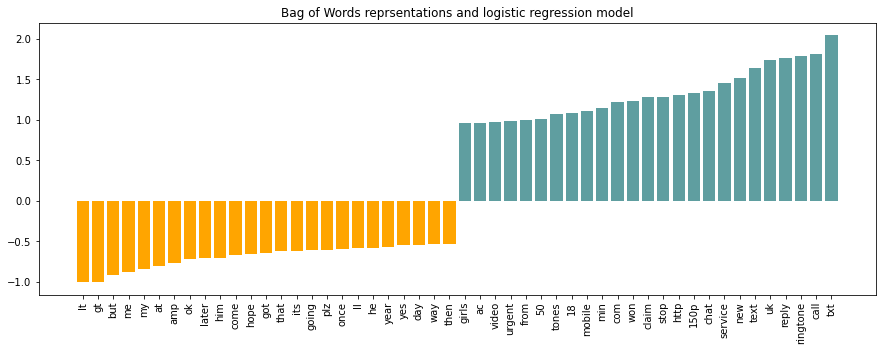

In [59]:
visualize_coefficients('Bag of Words reprsentations and logistic regression model', model1, feature_names)

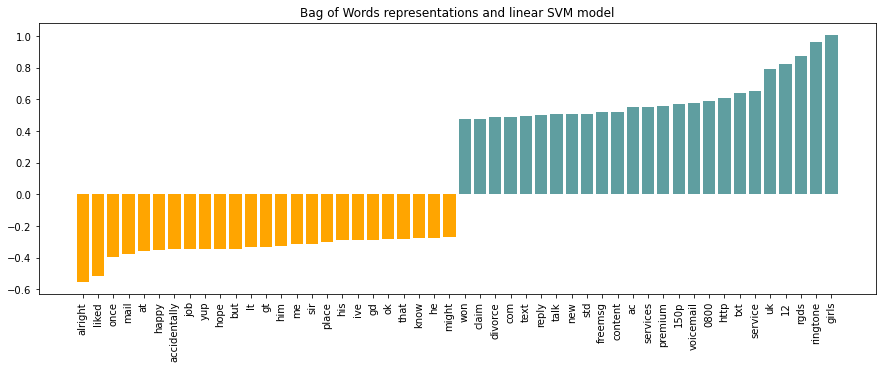

In [60]:
visualize_coefficients('Bag of Words representations and linear SVM model', model2, feature_names)

Model *k* nearest neighbors does not have an explicit form, that is, it is not determined by some coefficients, so we cannot get to the most relevant words in this way.

## Text representation using the TF-IDF method

Now we well try with TF-IDF representations and train same types of classification models in order to compare them with the previous ones. When building a vocabulary, we exclude words that appear less than 2 times.

In [61]:
sms_tfidf_vectorizer = TfidfVectorizer(min_df=2)

Building vocabulary based on instances of the training set:

In [62]:
sms_tfidf_vectorizer.fit(x_train)

TfidfVectorizer(min_df=2)

Size of the built vocabulary (same as with the Bags of Words method):

In [63]:
feature_names = sms_tfidf_vectorizer.get_feature_names()

In [64]:
len(feature_names)

3209

Vectorization of training and test set text data:

In [65]:
x_train_vectorized = sms_tfidf_vectorizer.transform(x_train)
x_test_vectorized = sms_tfidf_vectorizer.transform(x_test)

### Model 1 - logisticka regresija

We construct a simple logistic regression model and train it on a vectorized training set.

In [66]:
model1 = linear_model.LogisticRegression()

In [67]:
model1.fit(x_train_vectorized, y_train)

LogisticRegression()

Accuracy of the model on the training and test set:

In [68]:
model1.score(x_train_vectorized, y_train)

0.976158585587999

In [69]:
model1.score(x_test_vectorized, y_test)

0.9690048939641109

Confusion matrix:

In [70]:
y_test_predicted = model1.predict(x_test_vectorized)

In [71]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1591,    1],
       [  56,  191]])

Note that the accuracy of the model trained on TF-IDF representations is slightly worse compared to the same model trained on Bag of Words representations. It is possible that accuracy and confusion matrix are not appropriate measures and that it was necessary to look at the values of other measures in both cases (e.g. AUC measures). Also, it may be that the TF-IDF measure in the default variant is not suitable for this problem and that better results may be obtained by logarithmizing the TF-part of the measure.

### Model 2 - linearni SVM

We construct a linear SVM (Support Vector Machine) model and train it on a vectorized training set.

In [72]:
model2 = svm.LinearSVC()

In [73]:
model2.fit(x_train_vectorized, y_train)

LinearSVC()

Accuracy of the model on the training and test set:

In [74]:
model2.score(x_train_vectorized, y_train)

0.997856951513528

In [75]:
model2.score(x_test_vectorized, y_test)

0.9864056552474171

Confusion matrix:

In [76]:
y_test_predicted = model2.predict(x_test_vectorized)

In [77]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1590,    2],
       [  23,  224]])

Note that we obtained very similar results as in the case of the same model trained on Bag of Words representations.

### Model 3 - *k* najblizih suseda

We construct a *k* nearest neighbors classifier (observing the 4 nearest neighbors) and train it on a vectorized training set.

In [78]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=4)

In [79]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

Accuracy of the model on the training and test set:

In [80]:
model3.score(x_train_vectorized, y_train)

0.9373158317706938

In [81]:
model3.score(x_test_vectorized, y_test)

0.9222403480152257

Confusion matrix:

In [82]:
y_test_predicted = model3.predict(x_test_vectorized)

In [83]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1592,    0],
       [ 143,  104]])

Note that we got slightly better results compared to the same model trained at the Bag of Words representations.

<div class='alert alert-info'>
TO DO:
    
Analyze the values of the coefficients of all obtained models (those that have a parametric representation) and detect words that appear as the most relevant in all/most of models.    
</div>